<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [132]:
# librerias
import warnings
warnings.simplefilter('ignore')


import numpy as np
import pylab as plt
plt.rcParams['figure.figsize']=(15, 8)

from scipy.stats import bernoulli, beta   

from bayes import *

In [2]:
# datos
df = pd.read_csv('data/cookie_cats.csv')

In [25]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
# transformacion : separamos los grupos de control y testeo

In [38]:
ctrl = df[df['version']== 'gate_30']
ctrl.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,44700.0,4.987564e+06,2.881026e+06,116.0,2505469.0,4983631.0,7481496.75,9999710.0
sum_gamerounds,44700.0,5.245626e+01,2.567164e+02,0.0,5.0,17.0,50.00,49854.0


In [37]:
test = df[df['version']== 'gate_40']
test.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,45489.0,5.009073e+06,2.885496e+06,377.0,2517171.0,5007329.0,7510762.0,9999861.0
sum_gamerounds,45489.0,5.129878e+01,1.032944e+02,0.0,5.0,16.0,52.0,2640.0


# A/B TESTING BAYESIANO:

In [77]:
from statsmodels.stats import weightstats
from statsmodels.stats.weightstats import ztest

## DÍA 1

In [101]:
# muestreo

# IMPRESIONES Y CONVERSIONES PARA TEST Y CONTROL:

imp_control = ctrl.count()[0]
imp_test = test.count()[0]

conv_control = ctrl.retention_1.value_counts()[1]
conv_test = test.retention_1.value_counts()[1]

print(conv_control,',', conv_test ,'-----', imp_control,',',imp_test)

20034 , 20119 ----- 44700 , 45489


In [102]:
# testeo para retention_1:

CR_ctrl = conv_control/imp_control # conversion/impresion
CR_test = conv_test/imp_test

f'Tasas de conversión: CONTROL:{CR_ctrl}, TEST: {CR_test}'

'Tasas de conversión: CONTROL:0.4481879194630872, TEST: 0.44228274967574577'

In [112]:
# a priori:

a_C, b_C = 1+conv_control, 1+imp_control-conv_control  # 
a_T, b_T = 1+conv_test, 1+imp_test-conv_test

beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)

In [113]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [127]:
x=np.linspace(0.43, 0.46, 1000) 

def plot(control, test): 
    
    for bet, nom in zip(control, test):
        
        y=bet.pdf(x)          
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

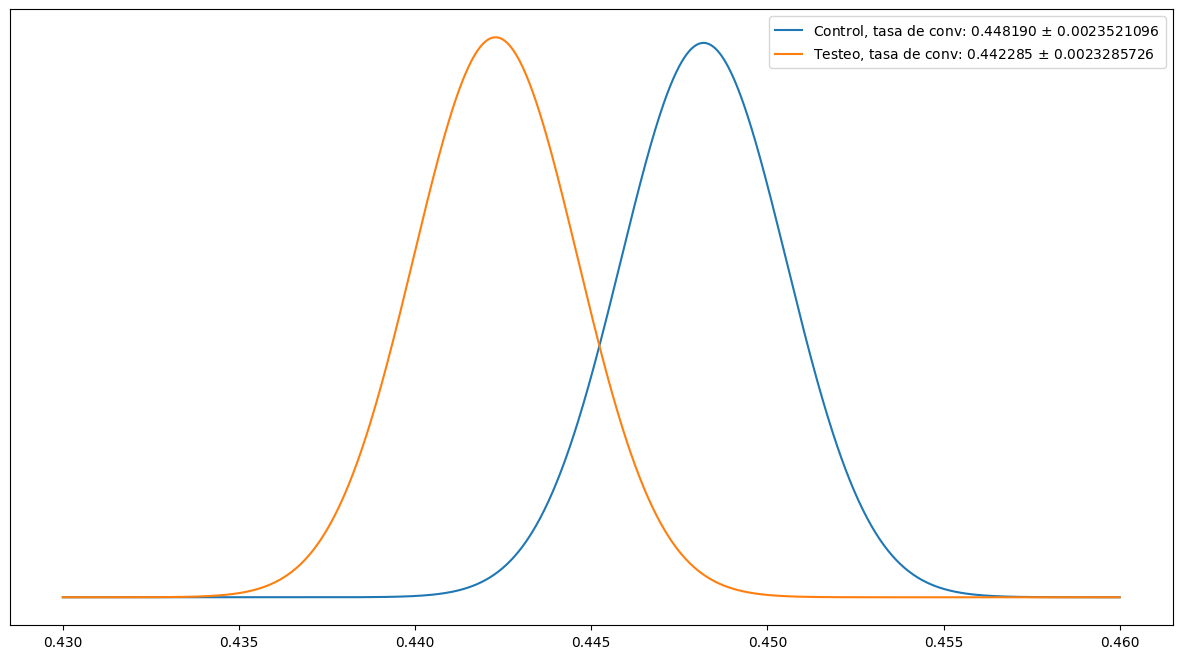

In [128]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [138]:
salto = (beta_control.mean() - beta_test.mean())/beta_test.mean()  # tasa de cambio relativa
prob = calc_prob(beta_control, beta_test)

prob , salto

(0.9627939748515354, 0.01335099887899125)

In [140]:
print ('El control aumenta la tasa de conversion en un {:2.2f}%,con una probabilidad del {:2.2f}%'.format(salto*100, prob*100))

El control aumenta la tasa de conversion en un 1.34%,con una probabilidad del 96.28%


# DIA 7

In [141]:
# testeo para retention_7

imp_control = ctrl.count()[0]
imp_test = test.count()[0]

conv_control = ctrl.retention_7.value_counts()[1]
conv_test = test.retention_7.value_counts()[1]

print(conv_control,',', conv_test ,'-----', imp_control,',',imp_test)


8502 , 8279 ----- 44700 , 45489


In [142]:
# testeo para retention_7:

CR_ctrl = conv_control/imp_control # conversion/impresion
CR_test = conv_test/imp_test

f'Tasas de conversión: CONTROL:{CR_ctrl}, TEST: {CR_test}'

'Tasas de conversión: CONTROL:0.19020134228187918, TEST: 0.18200004396667327'

In [143]:
# a priori:

a_C, b_C = 1+conv_control, 1+imp_control-conv_control  # 
a_T, b_T = 1+conv_test, 1+imp_test-conv_test

beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [148]:
x=np.linspace(0.17, 0.2, 1000) 

def plot(control, test): 
    
    for bet, nom in zip(control, test):
        
        y=bet.pdf(x)          
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

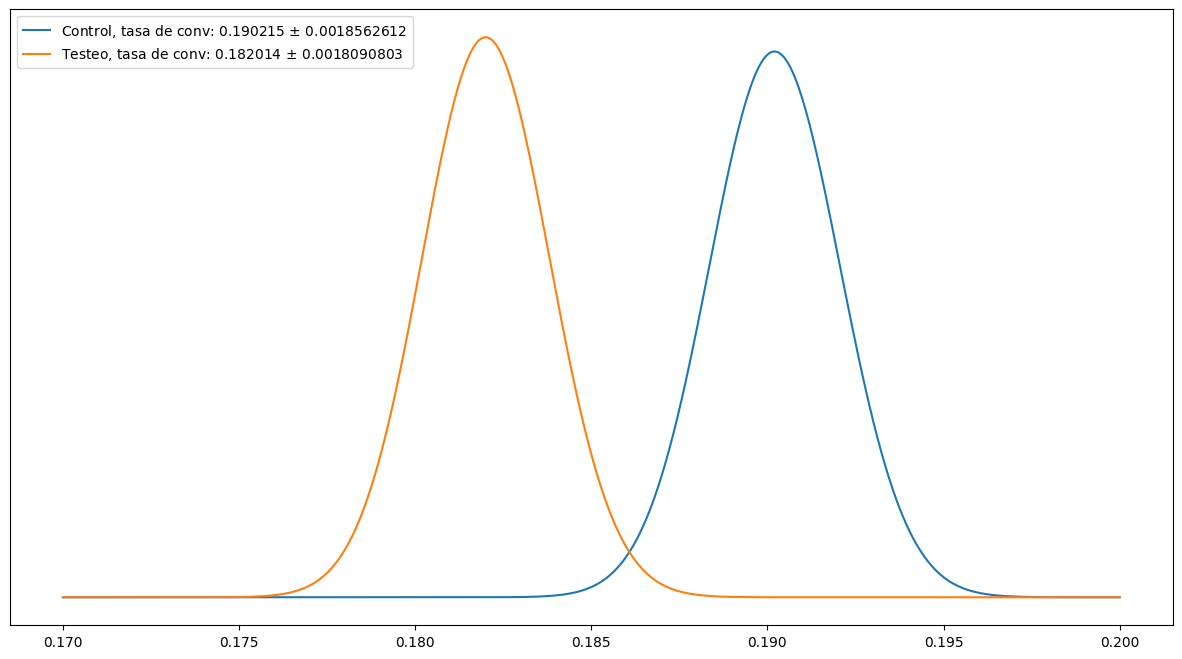

In [149]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [150]:
salto = (beta_control.mean() - beta_test.mean())/beta_test.mean()  # tasa de cambio relativa
prob = calc_prob(beta_control, beta_test)

In [151]:
prob , salto
print ('El control aumenta la tasa de conversion en un {:2.2f}%,con una probabilidad del {:2.2f}%'.format(salto*100, prob*100))

El control aumenta la tasa de conversion en un 4.51%,con una probabilidad del 99.92%


## Conclusiones:

El control aumenta la tasa de conversion en un 1.34%,con una probabilidad del 96.28% \
El control aumenta la tasa de conversion en un 4.51%,con una probabilidad del 99.92%


## Explica detalladamente las conclusiones obtenidas de tu testeo.

Según los resultados obtenido el grupo control(gate_30) tiene mayor tasa de conversión en ambos casos(retention_1 y retention_7). Es mayor en retention_7 lo cual es lógico ya que cuanto mayor sea el tiempo que se quede un jugador mayor es la probabilidad que se quede